In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")
df.head()

,Patient_ID,Condition,Time_Split,SCL_Mean,SCL_STD,SCR_Peaks_Count,EDA_Raw_Mean,EDA_Raw_STD,EDA_Raw_Dynamic_Range,ECG_Mean,...,HRV_MedianRR,HRV_HF,HRV_LF,HRV_LF_HF_Ratio,HRV_SampEN,PANAS_PA,PANAS_NA,Mod_STAI,Stress_label,Anxiety_Level
0,S10,Transition,1,0.728458,0.003345,42000,0.728551,0.013975,0.419617,0.001918,...,624.285714,0.005045,0.044406,8.801894,0.443931,NaN,NaN,NaN,NaN,NaN
1,S10,Transition,2,0.734615,0.002419,42000,0.734707,0.013419,0.299454,0.001407,...,655.714286,0.006522,0.007772,1.191655,1.032654,NaN,NaN,NaN,NaN,NaN
2,S10,Base,3,0.744500,0.002815,42000,0.744245,0.013809,0.286484,0.001372,...,634.285714,0.004447,0.026497,5.958112,0.997516,18.0,12.0,11.0,0.0,1.0
3,S10,Base,4,0.749116,0.001900,42000,0.749359,0.013476,0.398254,0.001438,...,594.285714,0.003043,0.010728,3.525311,1.134330,18.0,12.0,11.0,0.0,1.0
4,S10,Base,5,0.754868,0.002349,42000,0.755048,0.013479,0.315475,0.001172,...,582.857143,0.009533,0.041228,4.324815,0.449403,18.0,12.0,11.0,0.0,1.0


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

## Static Feature Analysis

In [6]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")
feature_cols = [
    'SCL_Mean', 'SCL_STD', 'SCR_Peaks_Count',
    'HRV_RMSSD', 'HRV_SDNN', 'HRV_pNN50',
    'HRV_MeanRR', 'HRV_MedianRR', 'HRV_HF',
    'HRV_LF', 'HRV_LF_HF_Ratio', 'HRV_SampEN'
]
df = df.dropna(subset=['PANAS_PA'] + feature_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 2 to 1441
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             846 non-null    object 
 1   Condition              846 non-null    object 
 2   Time_Split             846 non-null    int64  
 3   SCL_Mean               846 non-null    float64
 4   SCL_STD                846 non-null    float64
 5   SCR_Peaks_Count        846 non-null    int64  
 6   EDA_Raw_Mean           846 non-null    float64
 7   EDA_Raw_STD            846 non-null    float64
 8   EDA_Raw_Dynamic_Range  846 non-null    float64
 9   ECG_Mean               846 non-null    float64
 10  ECG_Min                846 non-null    float64
 11  ECG_Max                846 non-null    float64
 12  ECG_Median             846 non-null    float64
 13  ECG_STD                846 non-null    float64
 14  HRV_RMSSD              846 non-null    float64
 15  HRV_SDNN  

In [7]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")

# Define features (NO time windowing)
feature_cols = [
    'SCL_Mean', 'SCL_STD', 'SCR_Peaks_Count',
    'HRV_RMSSD', 'HRV_SDNN', 'HRV_pNN50',
    'HRV_MeanRR', 'HRV_MedianRR', 'HRV_HF',
    'HRV_LF', 'HRV_LF_HF_Ratio', 'HRV_SampEN'
]

# Drop NaNs and infinite values
df = df.dropna(subset=['PANAS_PA'] + feature_cols)
df = df.drop(columns="HRV_SDANN")
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Prepare data arrays
X = df[feature_cols].values
y = df['PANAS_PA'].values
group_ids = df['Patient_ID'].values

# Define models and parameter grids
models = {
    "LinearRegression": (LinearRegression(), {}),
    "RandomForest": (RandomForestRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3]
    }),
    "DecisionTree": (DecisionTreeRegressor(), {
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3]
    }),
    "XGBoost": (XGBRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1],
        "reg_lambda": [1, 5],
        "subsample": [0.7, 1.0]
    }),
    "LightGBM": (LGBMRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.01, 0.1],
        "reg_lambda": [0.0, 1.0]
    }),
    "AdaBoost": (AdaBoostRegressor(), {
        "n_estimators": [50, 100],
        "learning_rate": [0.1, 0.5, 1.0]
    }),
    "SVM": (SVR(), {
        "kernel": ["linear", "rbf"],
        "C": [0.1, 1.0, 10.0],
        "epsilon": [0.1, 0.5, 1.0]
    }),
}

# List of models that require feature scaling
scale_sensitive_models = ["SVM", "LinearRegression"]

# Prepare cross-validation
gkf = GroupKFold(n_splits=5)
evaluation_results = []

# Loop through models
for model_name, (model, param_grid) in models.items():
    all_preds, all_true = [], []

    for train_idx, test_idx in gkf.split(X, y, groups=group_ids):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

         # Apply MinMaxScaler only if model is scale-sensitive
        if model_name in scale_sensitive_models:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        all_preds.extend(y_pred)
        all_true.extend(y_test)

    # Metrics
    mse = mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)
    r2 = r2_score(all_true, all_preds)

    evaluation_results.append({
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Best Params': grid.best_params_,
    })

# Convert to DataFrame
results_df = pd.DataFrame([{k: v for k, v in r.items()} for r in evaluation_results])
print(results_df)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 673, number of used features: 11
[LightGBM] [Info] Start training from score 25.760773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 673, number of used features: 11
[LightGBM] [Info] Start training from score 24.686478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] Start training from score 25.295252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] Start training from score 23.848665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2453
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] Start training from score 23.943620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [8]:
pd.set_option('display.max_colwidth', None) # Show full width of each column

results_df

,Model,MSE,MAE,R2,Best Params
0,LinearRegression,48.884498,5.721484,-0.012700,{}
1,RandomForest,56.681025,6.303979,-0.174215,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}"
2,DecisionTree,60.330126,6.302093,-0.249810,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}"
3,XGBoost,50.139813,5.859655,-0.038706,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 1, 'subsample': 0.7}"
4,LightGBM,55.175248,6.110217,-0.143021,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 1.0}"
5,AdaBoost,52.518228,5.966309,-0.087977,"{'learning_rate': 0.1, 'n_estimators': 50}"
6,SVM,49.904298,5.706685,-0.033827,"{'C': 1.0, 'epsilon': 1.0, 'kernel': 'linear'}"


In [9]:
results_df.to_csv("/content/drive/MyDrive/Capstone/results/static_PA_best_models.csv", index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] Start training from score 23.943620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

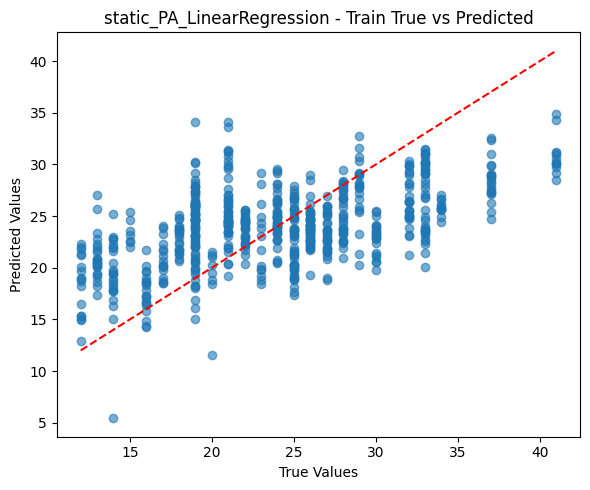

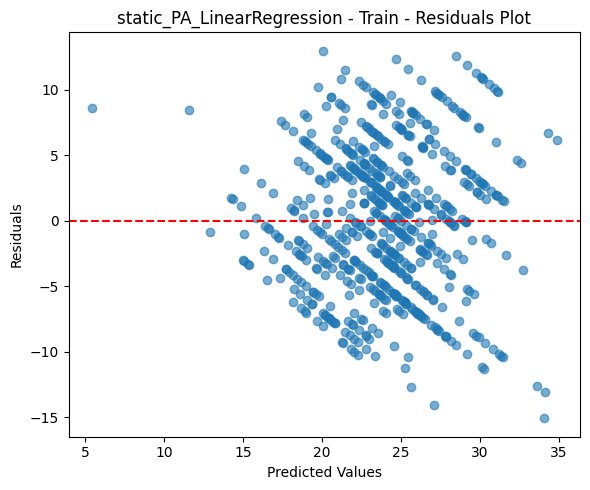

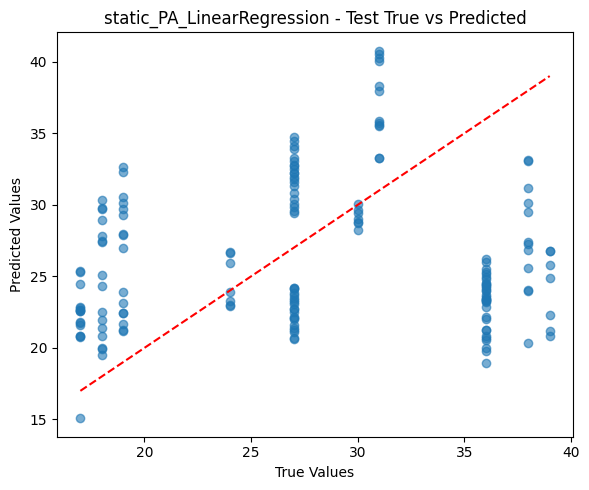

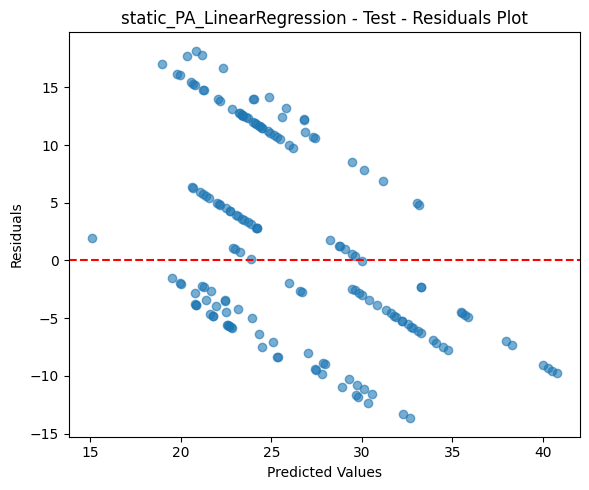

Evaluating RandomForest...


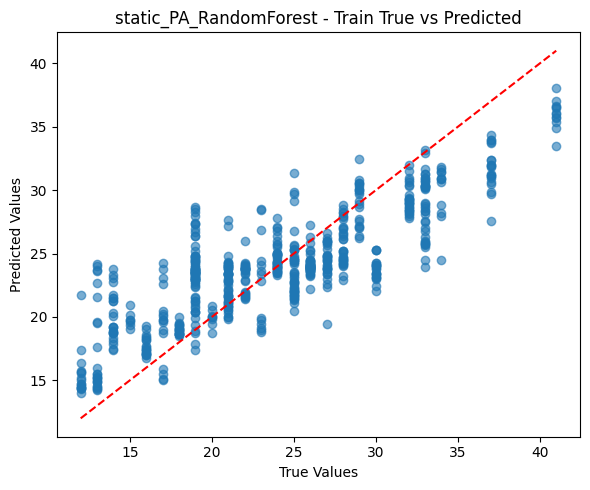

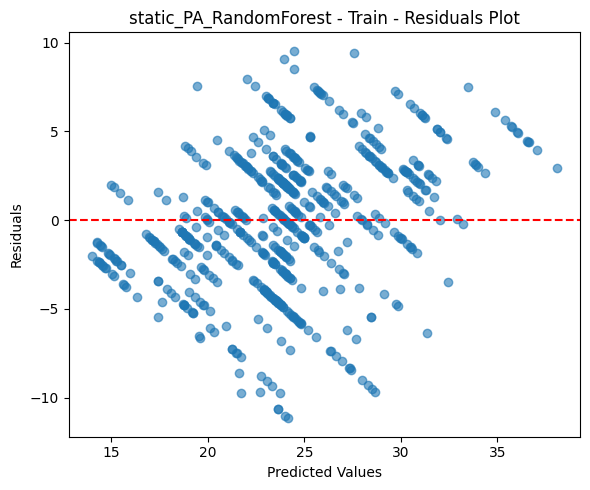

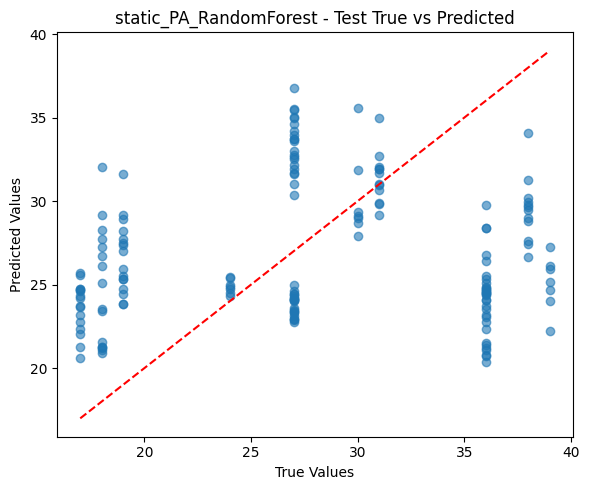

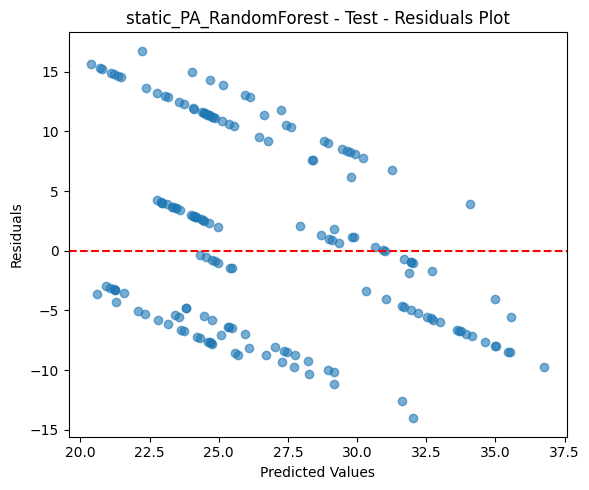

Evaluating DecisionTree...


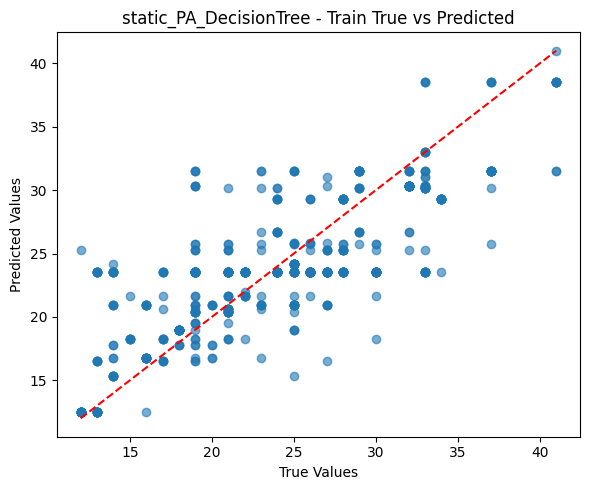

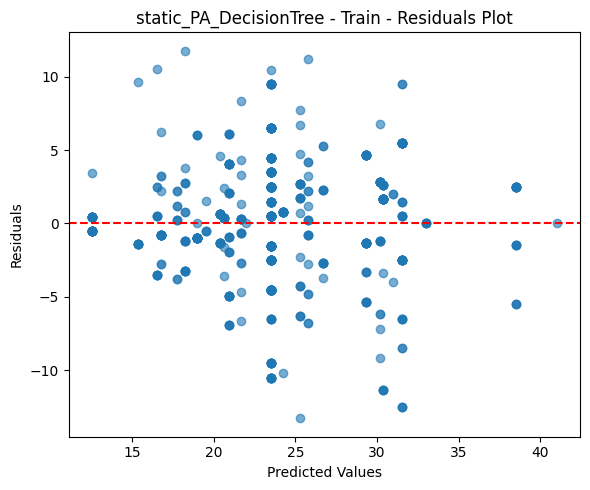

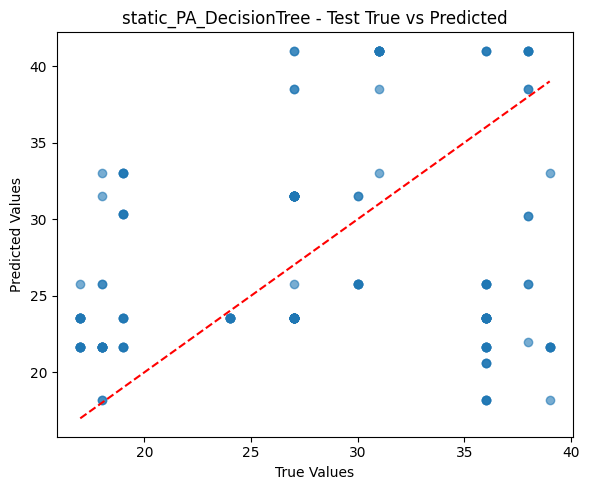

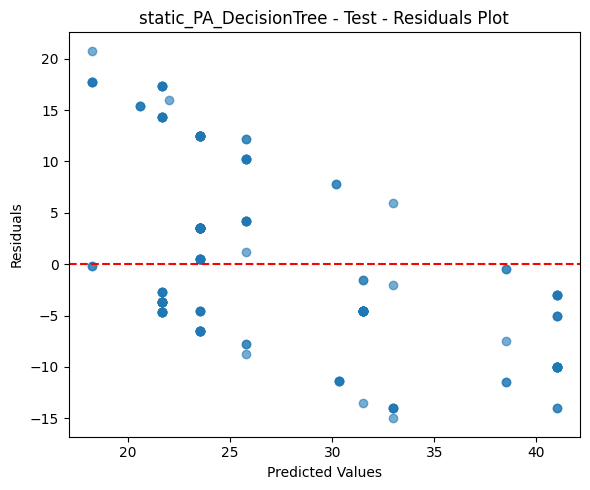

Evaluating XGBoost...


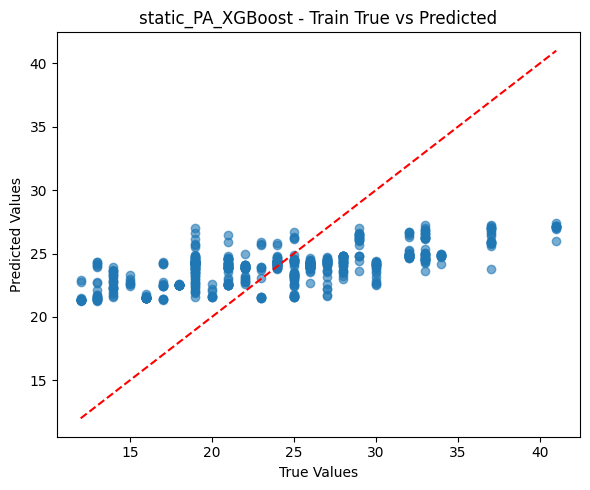

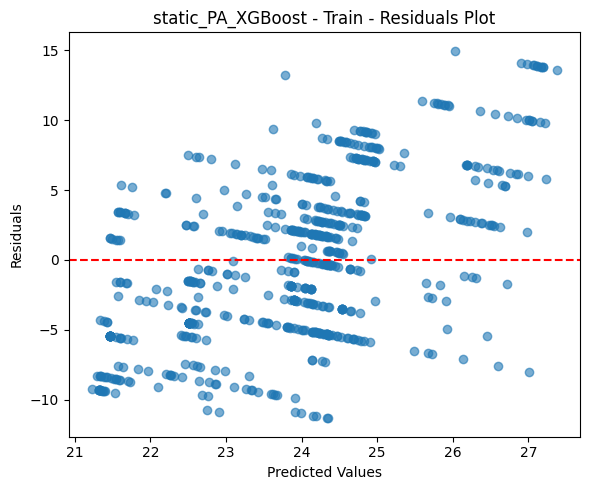

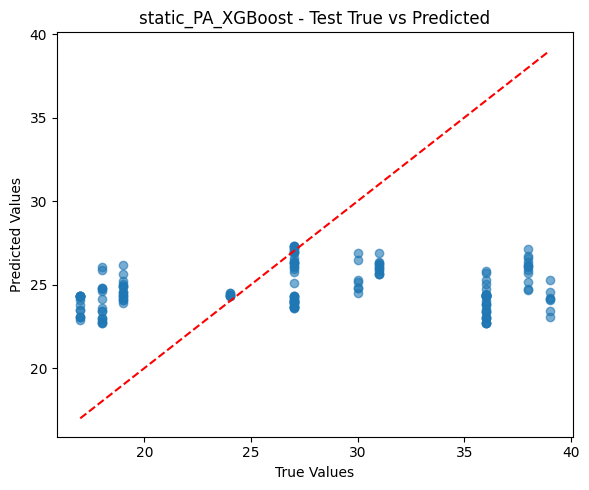

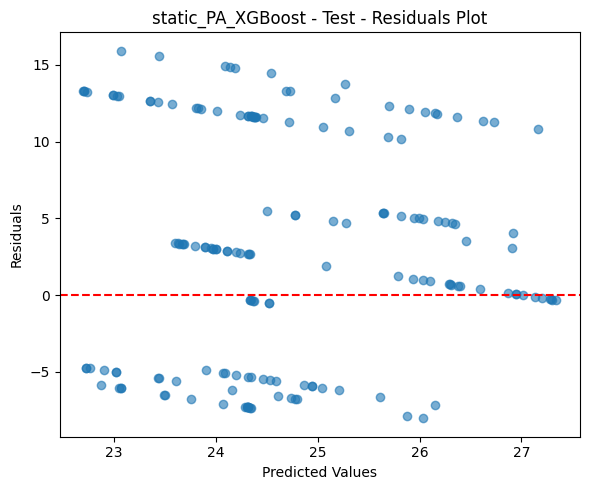

Evaluating LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


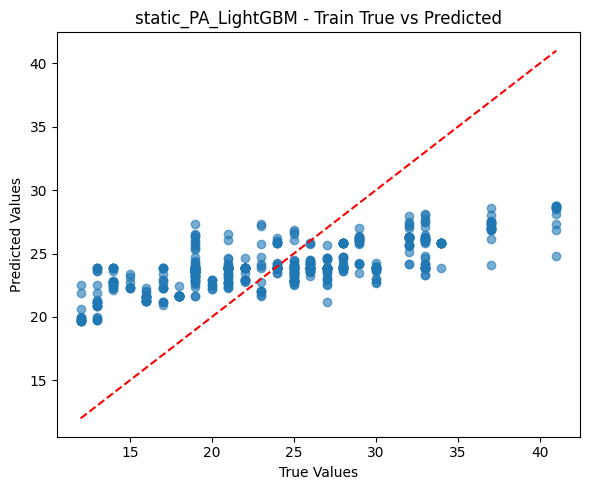

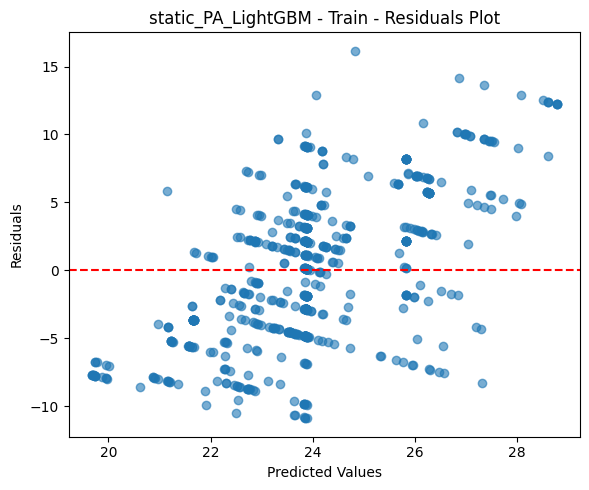

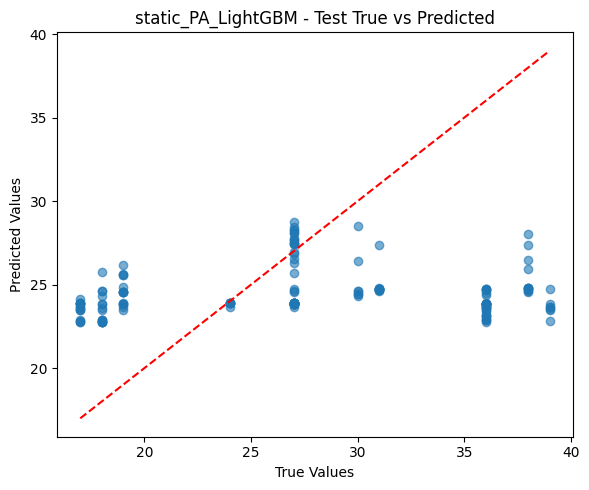

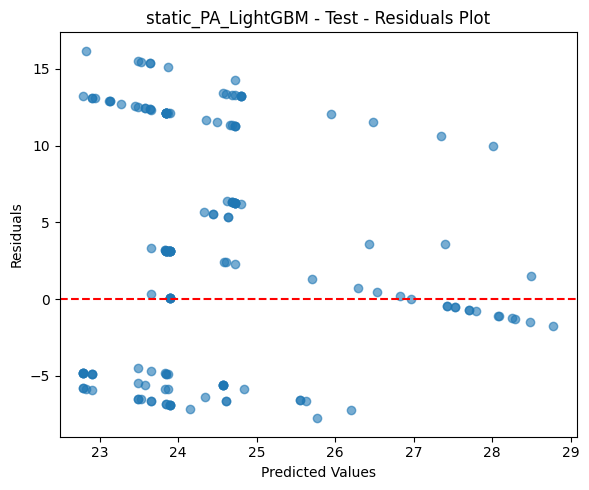

Evaluating AdaBoost...


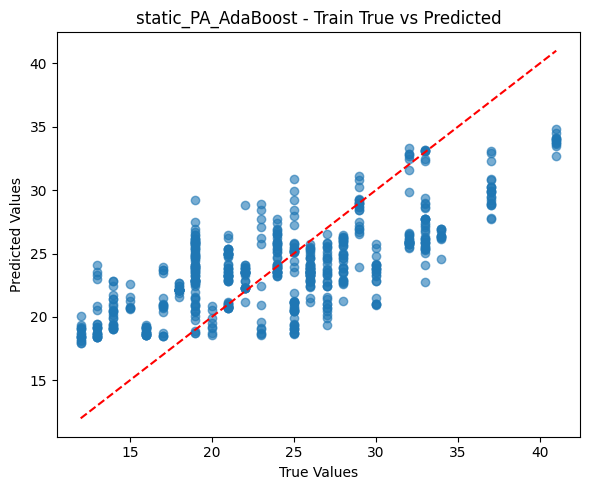

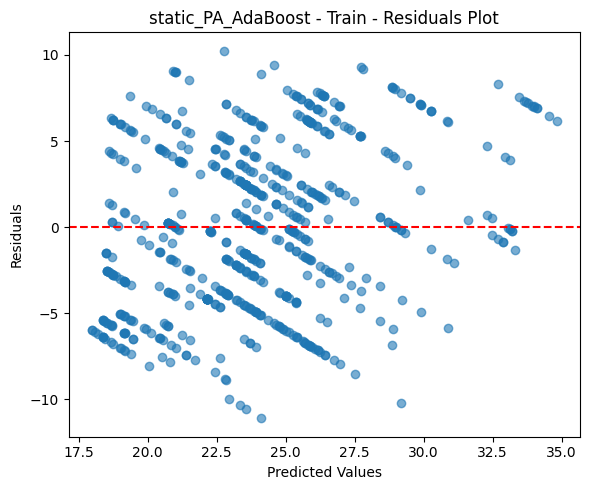

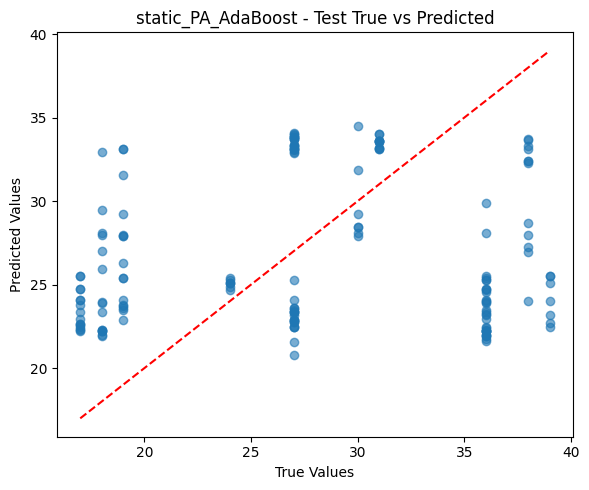

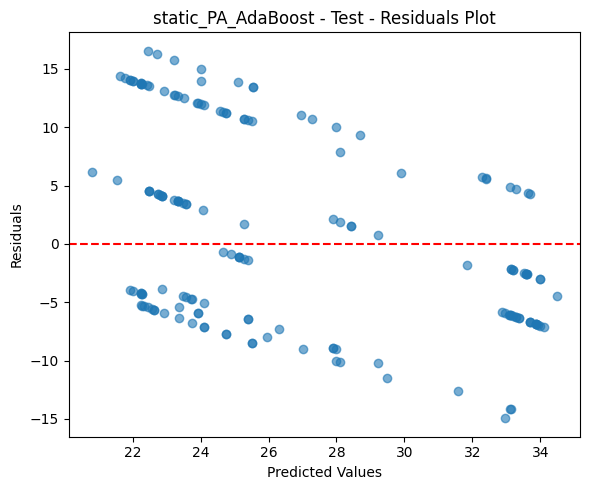

Evaluating SVM...


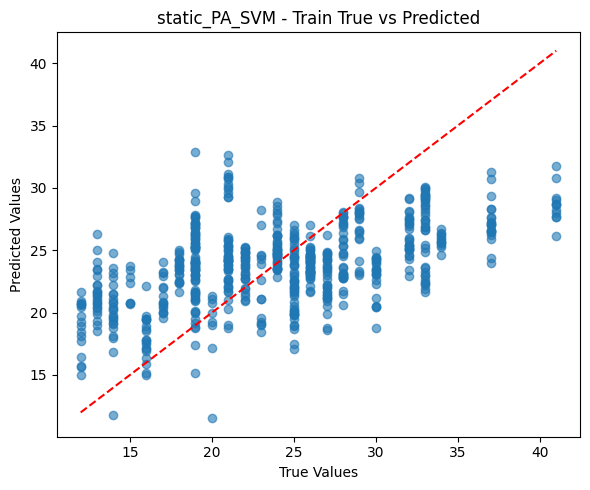

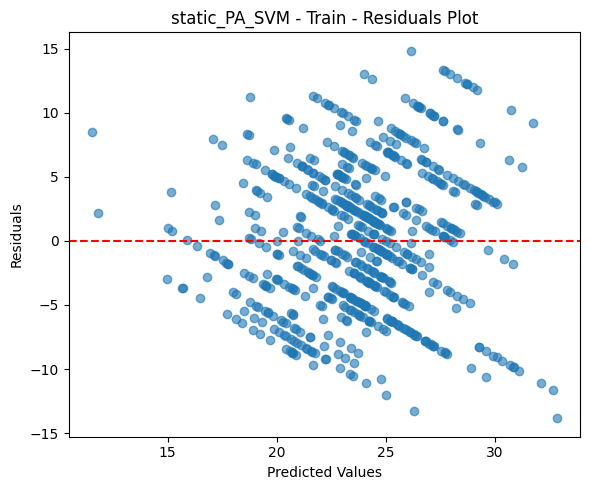

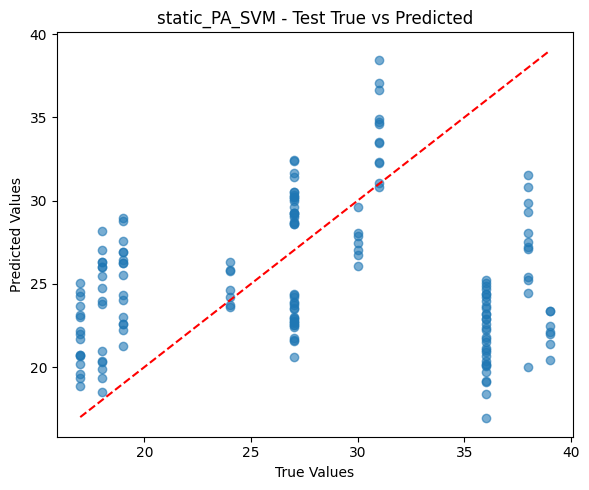

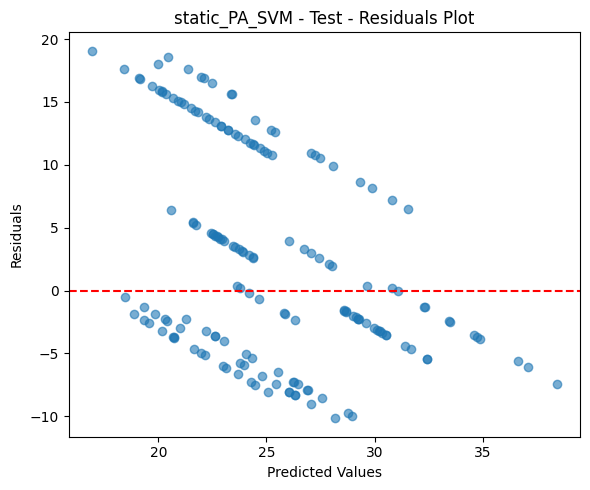

              Model  Train MSE   Test MSE  Train MAE  Test MAE  Train R2  \
0  LinearRegression  30.011172  76.142795   4.549220  7.471308  0.312126   
1      RandomForest  14.148572  65.486894   3.024862  6.933901  0.675706   
2      DecisionTree  16.703255  79.757521   3.135708  7.403919  0.617151   
3           XGBoost  32.371103  63.202001   4.726931  6.613475  0.258035   
4          LightGBM  29.387413  65.821215   4.535314  6.776259  0.326423   
5          AdaBoost  22.110321  69.423692   3.998396  7.226699  0.493218   
6               SVM  31.347735  75.710149   4.657305  7.063339  0.281491   

    Test R2  
0 -0.379644  
1 -0.186568  
2 -0.445140  
3 -0.145168  
4 -0.192626  
5 -0.257900  
6 -0.371805  


In [10]:
from evaluation import full_regression_evaluation

# Define your best models (replace with actual fitted GridSearchCV.best_estimator_)
best_models = {
    "LinearRegression": LinearRegression().fit(X_train, y_train),
    "RandomForest": RandomForestRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50).fit(X_train, y_train),
    "DecisionTree": DecisionTreeRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=2).fit(X_train, y_train),
    "XGBoost": XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=50, reg_lambda=1, subsample=0.7).fit(X_train, y_train),
    "LightGBM": LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=50, reg_lambda=1.0).fit(X_train, y_train),
    "AdaBoost": AdaBoostRegressor(learning_rate=0.1, n_estimators=100).fit(X_train, y_train),
    "SVM": SVR(C=1.0, kernel='linear', epsilon=1.0).fit(X_train, y_train)
    }

# Store evaluation results
evaluation_summaries = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    results = full_regression_evaluation(model, X_train, y_train, X_test, y_test, model_name, data_type="static_PA")

    evaluation_summaries.append({
        'Model': model_name,
        'Train MSE': results['Train']['MSE'],
        'Test MSE': results['Test']['MSE'],
        'Train MAE': results['Train']['MAE'],
        'Test MAE': results['Test']['MAE'],
        'Train R2': results['Train']['R2'],
        'Test R2': results['Test']['R2']
    })

# Convert to DataFrame for comparison
eval_df = pd.DataFrame(evaluation_summaries)
print(eval_df)


In [11]:
eval_df.to_csv("/content/drive/MyDrive/Capstone/results/static_PA_best_models_eval.csv", index=False)

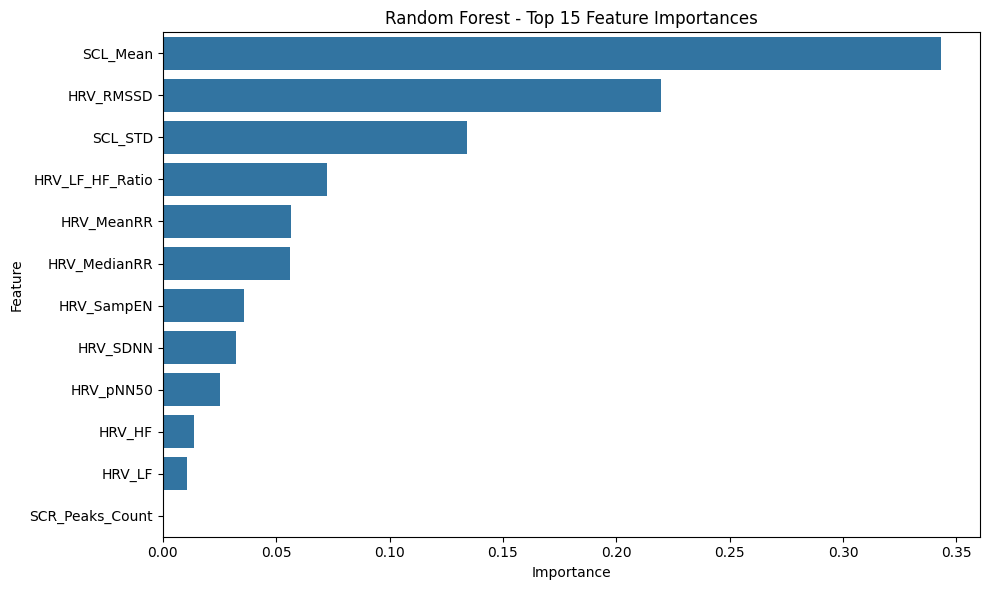

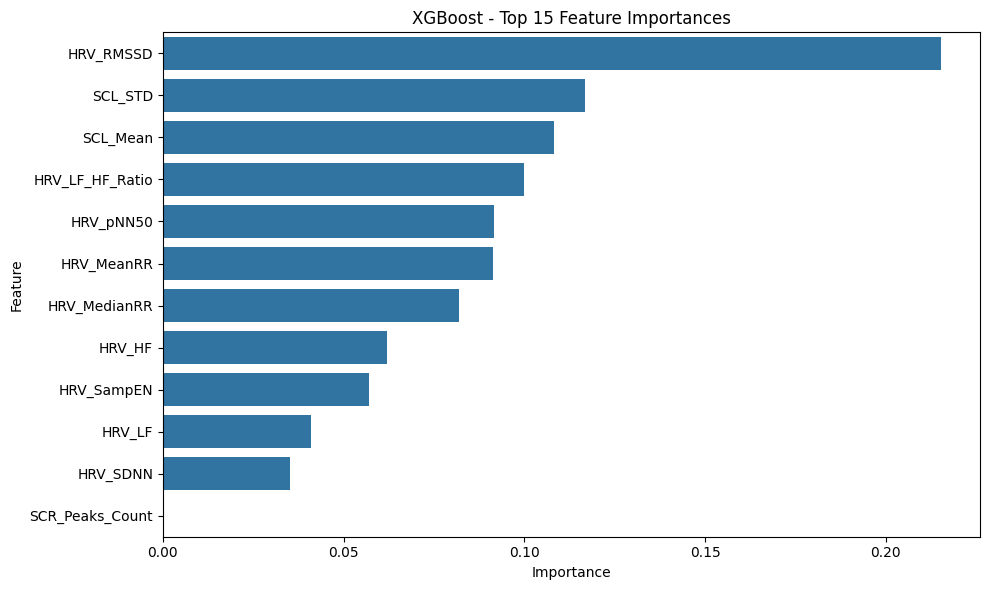

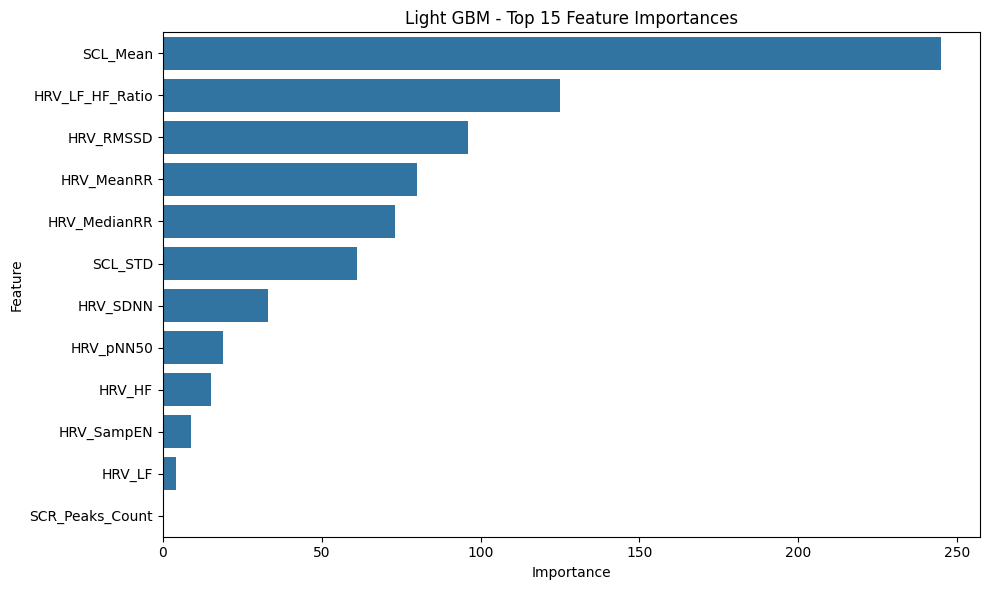

In [13]:
import os
from feature_importance import plot_feature_importance

best_rf_model = best_models['RandomForest']
best_xgb_model = best_models['XGBoost']
best_lgbm_model = best_models['LightGBM']
# Example usage with your trained models
plot_feature_importance(best_rf_model, feature_cols, model_name="Random Forest", save_path = "/content/drive/MyDrive/Capstone/figures/static_rf_PA_importance.png")
plot_feature_importance(best_xgb_model, feature_cols, model_name="XGBoost", save_path = "/content/drive/MyDrive/Capstone/figures/static_xgb_PA_importance.png")
plot_feature_importance(best_lgbm_model, feature_cols, model_name="Light GBM", save_path = "/content/drive/MyDrive/Capstone/figures/static_lgbm_PA_importance.png")
